# Network Gaussian example N=3

In [1]:
from IPython import get_ipython
get_ipython().run_line_magic("reset","-f")

from PyPackageJonas import *

figures_path = "C:/Users/jonas/Git/Analysis-of-Production-flow-systems-with-focus-on-industry/Latex Thesis/figures/"

In [2]:
# First index is different variables
d = 3
n_sample = 10_000


s1 = np.array([0.07, 0.3, 0.9])
s2 = np.array([1,1,1])
s3 = np.array([1,2,3])




mean = np.zeros(d)
cor = np.eye(d)

cor[0,1] = 0.9





cor = np.triu(cor, k = 1) + np.tril(cor, k = -1)
cor = np.eye(d) + cor + cor.T
L_cor = np.linalg.cholesky(cor)
Z = np.random.default_rng().multivariate_normal(mean = mean, cov = np.eye(d), size = n_sample).T

In [3]:

X1 = np.diag(s1) @ L_cor @ Z
X2 = np.diag(s2) @ L_cor @ Z
X3 = np.diag(s3) @ L_cor @ Z


Y1 = np.exp(X1)
Y2 = np.exp(X2)
Y3 = np.exp(X3)



# # Normalize
# # X = ( X - X.mean() ) / X.std()

# X **=  0.1

In [4]:
Y = Y1

In [5]:
# Prepare Kernels, transformed data to uniform (from kernel), Scott's optimal bandwiths
kernels_Y = [gaussian_kde(Y[i,:]) for i in range(d)]

U = np.vstack( [np.array([kernels_Y[i].integrate_box_1d(-np.inf, y_i) for y_i in Y[i,:]]) for i in tqdm(range(d)) ])
kernels_U = [gaussian_kde(U[i,:]) for i in range(d)]

h = np.array([(kernels_Y[i].covariance**0.5)[0,0] for i in range(d)])

  0%|          | 0/3 [00:00<?, ?it/s]

100%|██████████| 3/3 [00:14<00:00,  4.76s/it]


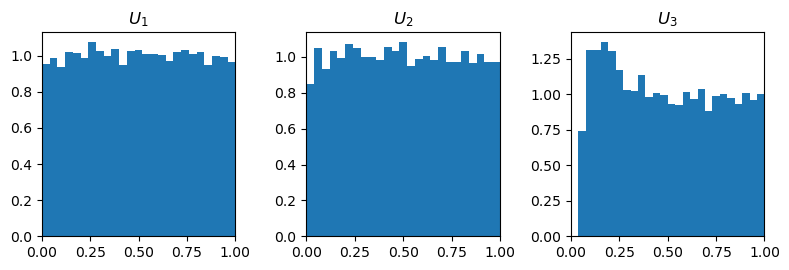

In [6]:
n_cols = int(np.ceil(np.sqrt(d)))
n_rows = int(np.ceil(d / n_cols))
# fig, ax = plt.subplots(n_rows,n_cols, figsize=(15,15))
fig, ax = plt.subplots(1,3, figsize=(8,2.8))

for i in range(d):
    ax.flat[i].hist(U[i,:], density=True, bins = 25)
    ax.flat[i].set_title(f"$U_{i+1}$")
    ax.flat[i].set_xlim([0,1])

fig.tight_layout()
# Gaussian 3x3 small s uniforms
# Gaussian 3x3 medium s uniforms
# Gaussian 3x3 large s uniforms
# Gaussian 3x3 large s power uniforms


# plt.savefig(figures_path + "ND examples/Gaussian 3x3 large s uniforms.pdf", bbox_inches='tight')

In [7]:
KolmogorovSmirnovTestUnif(U[0])
print()
KolmogorovSmirnovTestUnif(U[1])
print()
KolmogorovSmirnovTestUnif(U[2]);

Test-stat. :          0.005618781878187817
Adjusted test-stat. : 0.5625586223042303
p-value :             0.9096524993415896

Test-stat. :          0.0072119611961196095
Adjusted test-stat. : 0.722069488112811
p-value :             0.6742513828386276

Test-stat. :          0.051206380638063806
Adjusted test-stat. : 5.12683915650165
p-value :             2.9554320386557773e-23


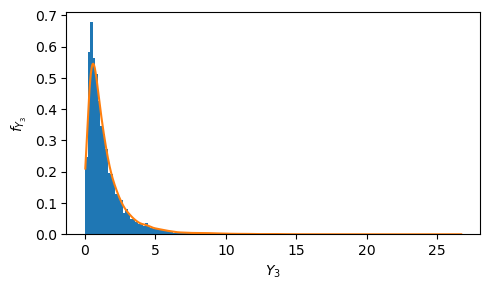

In [8]:
# densities
fig, ax = plt.subplots(1,1,figsize=(5,3))
ax.hist(Y[2,:],bins = 150, density=True)

# x_lim = [-200,200]

xx = np.linspace(Y[2,:].min(), Y[2,:].max(), 1000)
# xx = np.linspace(x_lim[0], x_lim[1], 1000)
pdf = kernels_Y[2](xx)
ax.plot(xx,pdf)
# ax.set_xlim(*x_lim)
ax.set_xlabel("$Y_3$")
ax.set_ylabel("$f_{Y_3}$")

fig.tight_layout()

# plt.savefig(figures_path + "ND examples/Gaussian 3x3 large s power X3 KDE.pdf", bbox_inches='tight')

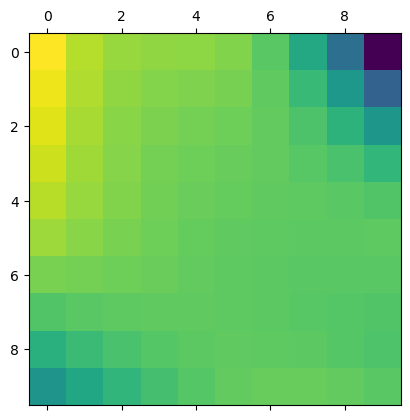

In [118]:
# import scipy.interpolate

xx, yy = np.meshgrid(np.linspace(0,1,10), np.linspace(0,1,10))
# x_edges, y_edges = np.mgrid[0:1:21j, 0:1:21j]
# x = x_edges[:-1, :-1] + np.diff(x_edges[:2, 0])[0] / 2.
# y = y_edges[:-1, :-1] + np.diff(y_edges[0, :2])[0] / 2.

tck = scipy.interpolate.bisplrep(u_i,u_j,np.ones(u_i.__len__()))
# plt.matshow(scipy.interpolate.bisplev(xx[0,:], yy[:,0], tck))
# scipy.interpolate.bisplev(xx[0,:], yy[:,0],tck)
temp = scipy.interpolate.bisplev(xx[0,:], yy[:,0], tck)
plt.matshow(temp)

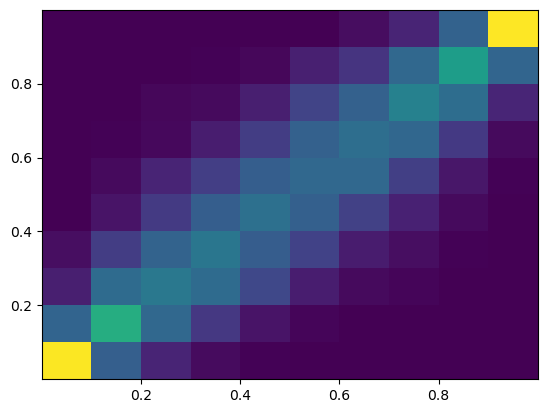

In [102]:
plt.hist2d(u_i, u_j);

In [92]:
G = np.zeros((N,N))

count = 0


for i in range(N-1):
    kernel_i = kernels_U[i]
    # h_i = h[i]
    u_i = U[i,:]
    for j in range(i+1, N):
        print(f"{ count } / { (N*(N-1)/2) :3.0f}    [{100*count/ (N*(N-1)/2) :7.2f}%]    ({i}, {j})\033[K", end ="\r")

        u_j = U[j,:]

        kernel_ij = gaussian_kde(np.vstack([u_i,u_j]))

        d_vol = kernel_ij.integrate_box(
                low_bounds = [0,0],
                high_bounds = [1,1]
            )
        
        # Simple normalization of KDE such that integrates to 1 (no jackknifing)
        G[i,j] = G[j,i] = \
            scipy.integrate.dblquad(
                lambda x,y : 
                    kernel_ij.pdf(np.vstack([x,y])) * \
                    kernel_ij.logpdf(np.vstack([x,y])),
                0,1,
                0,1
            )[0] / d_vol - np.log(d_vol)

        count += 1
        print(f"{ count } / { (N*(N-1)/2) :3.0f}    [{100*count/ (N*(N-1)/2) :7.2f}%]    ({i}, {j})\033[K", end ="\r")
        

KeyboardInterrupt: 

In [96]:
G = -0.5 * np.log( 1 - cor**2 )
np.fill_diagonal(G, 0)
G

C:\Users\jonas\AppData\Local\Temp\ipykernel_24688\3086811070.py:1: RuntimeWarning: divide by zero encountered in log
  G = -0.5 * np.log( 1 - cor**2 )


array([[0.        , 0.8303656 , 0.53370218],
       [0.8303656 , 0.        , 0.8303656 ],
       [0.53370218, 0.8303656 , 0.        ]])

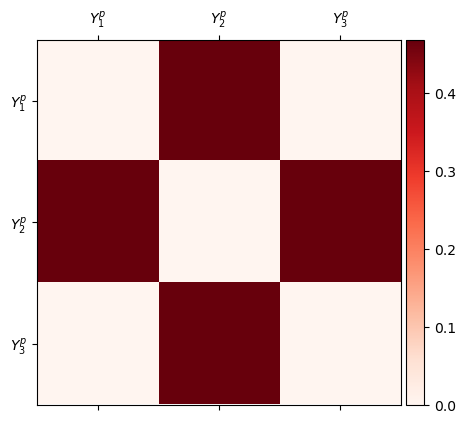

In [97]:
G_dir = ND(G, alpha=0, beta=0.99)

fig, ax = plt.subplots(1,1,figsize=(5,5))
r = ax.matshow(G_dir, cmap = "Reds", vmin=0)
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)

labels_select = [0,1,2]

plt.colorbar(r, cax=cax)
try:
    # ax.set_xticks([x+2 for x in range(labels_select.__len__())], labels_select, rotation='vertical');
    ax.set_xticks(
        [x for x in range(labels_select.__len__())], 
        [f"$Y_{x+1}" + "^p$" for x in range(labels_select.__len__())]
    );
    ax.set_yticks(
        [x for x in range(labels_select.__len__())], 
        [f"$Y_{x+1}" + "^p$" for x in range(labels_select.__len__())]
    );
except:
    None

# plt.savefig(figures_path + "ND examples/Gaussian 3x3 large s power.pdf", bbox_inches='tight')

In [ ]:
G_dir

array([[-3.28961429e-01,  6.61039932e-01,  8.29683536e-03],
       [ 6.61039932e-01, -3.28958680e-01,  8.12947036e-03],
       [ 8.29683536e-03,  8.12947036e-03, -2.01994901e-04]])

In [ ]:
n_mesh = 100
X1v, X2v = np.meshgrid(
    np.linspace(0,1,n_mesh), 
    np.linspace(0,1,n_mesh))

kernel_ij = gaussian_kde(np.vstack([U[0,:],U[1,:]]))

Zv = np.reshape(kernel_ij.evaluate(np.vstack([X1v.ravel(), X2v.ravel()])), (n_mesh,n_mesh))

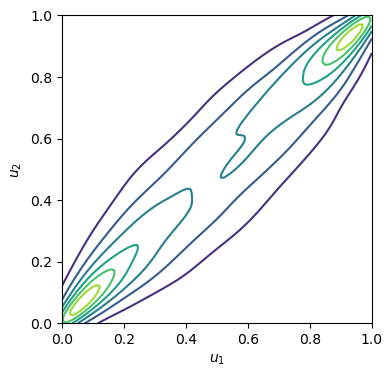

In [ ]:
fig, ax = plt.subplots(1,1, figsize=(4,4))
ax.contour(X1v, X2v, Zv );
ax.set_xlabel("$u_1$")
ax.set_ylabel("$u_2$")

plt.savefig(figures_path + "ND examples/Gaussian copula sample contour.pdf", bbox_inches='tight')

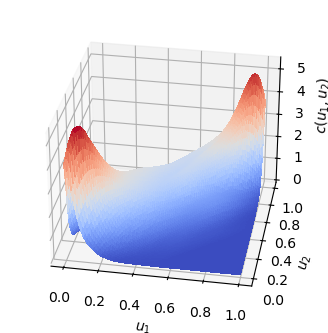

In [ ]:
fig, ax = plt.subplots(subplot_kw={"projection": "3d"}, figsize = (4,4))
ax.plot_trisurf(X1v.ravel(), X2v.ravel(), Zv.ravel(), cmap=cm.coolwarm ,linewidth=0.2, antialiased=False)
ax.view_init(30, -80, 0)
ax.set_xlabel("$u_1$")
ax.set_ylabel("$u_2$")
ax.set_zlabel("$c(u_1,u_2)$")
plt.savefig(figures_path + "ND examples/Gaussian copula sample pdf.pdf", bbox_inches='tight')

In [ ]:
# theoretical copula density for Gaussian
rho = 0.9
R = np.array([[1,rho],[rho,1]])
Ri = np.linalg.pinv(R) - np.identity(2)
n_mesh = 50

U1v, U2v = np.meshgrid(np.linspace(0.01,0.99,n_mesh), np.linspace(0.01 , 0.99,n_mesh))

U1v = U1v.ravel()
U2v = U2v.ravel()

X1v = scipy.stats.norm.ppf(U1v)
X2v = scipy.stats.norm.ppf(U2v)

Xv = np.vstack( (X1v, X2v ))


Zv = (Xv * (Ri @ Xv)).sum(axis=0)
Zv = 1 / np.sqrt(np.linalg.det(R)) * np.exp(-Zv / 2)

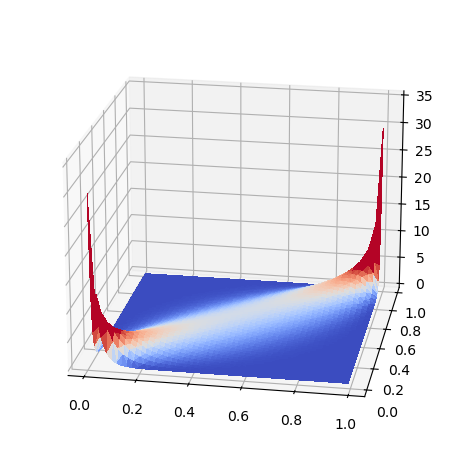

In [ ]:
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
ax.plot_trisurf(U1v, U2v, Zv, cmap=cm.coolwarm ,linewidth=0.2, antialiased=False, vmax = 5)
ax.set_zlim(0 , 35)
ax.view_init(20, -80, 0)
fig.tight_layout()
plt.savefig(figures_path + "ND examples/Gaussian copula theoretical pdf.pdf", bbox_inches='tight')

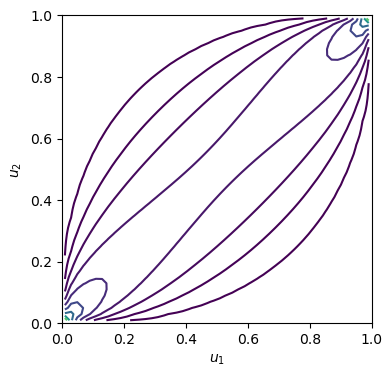

In [ ]:
fig, ax = plt.subplots(1,1, figsize=(4,4))
res = ax.contour(
    np.reshape(U1v, (n_mesh,n_mesh)), 
    np.reshape(U2v, (n_mesh,n_mesh)),
    np.reshape(Zv, (n_mesh,n_mesh)),
    levels=  32 * np.linspace(0.1,1,10)**3
    );
ax.set_xlabel("$u_1$")
ax.set_ylabel("$u_2$")
ax.set_xlim([0,1])
ax.set_ylim([0,1])

# np.exp(np.linspace(-7,3.5,10))
# np.sort([   4.,  8., 12., 16., 20., 24., 28., 32.] + [1,2] + [0.1] + [0.001] + [2.4])

plt.savefig(figures_path + "ND examples/Gaussian copula theoretical contour.pdf", bbox_inches='tight')

In [ ]:
np.log(32)

3.4657359027997265

In [ ]:
np.log(0.001)

-6.907755278982137

In [ ]:
np.exp(np.linspace(-7,3.5,10))

array([9.11881966e-04, 2.92829969e-03, 9.40356255e-03, 3.01973834e-02,
       9.69719679e-02, 3.11403224e-01, 1.00000000e+00, 3.21127054e+00,
       1.03122585e+01, 3.31154520e+01])

In [ ]:
32 * np.linspace(0,1,10)**3

array([ 0.        ,  0.04389575,  0.35116598,  1.18518519,  2.80932785,
        5.48696845,  9.48148148, 15.05624143, 22.47462277, 32.        ])

In [ ]:
res.levels

array([ 0.,  4.,  8., 12., 16., 20., 24., 28., 32.])

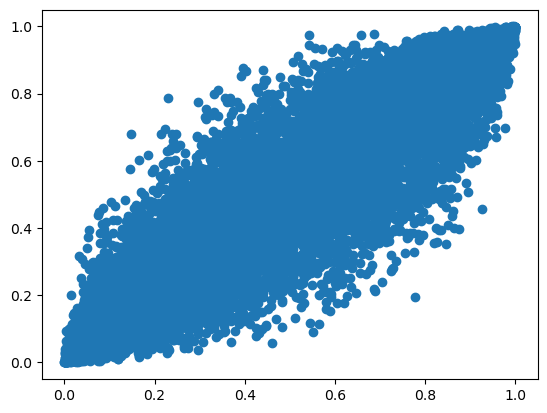

In [ ]:
plt.scatter(U[0,:], U[1,:])

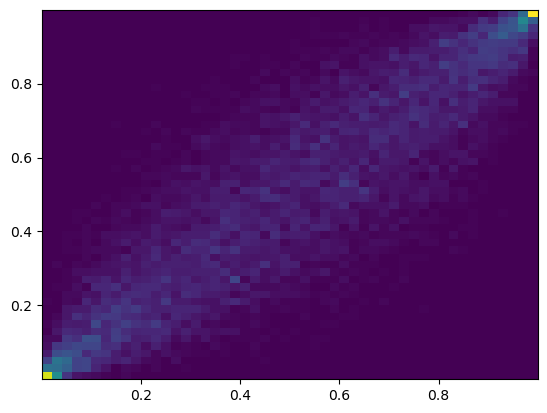

In [ ]:
res = plt.hist2d(U[0,:], U[1,:], density=True, bins = (50,50));

In [ ]:
print(res[0][0,0])
print(res[0][-1,-1])


500.1465103889542
200.05860415559238


In [ ]:
G

array([[0.        , 0.71841756, 0.01781815],
       [0.71841756, 0.        , 0.01769672],
       [0.01781815, 0.01769672, 0.        ]])

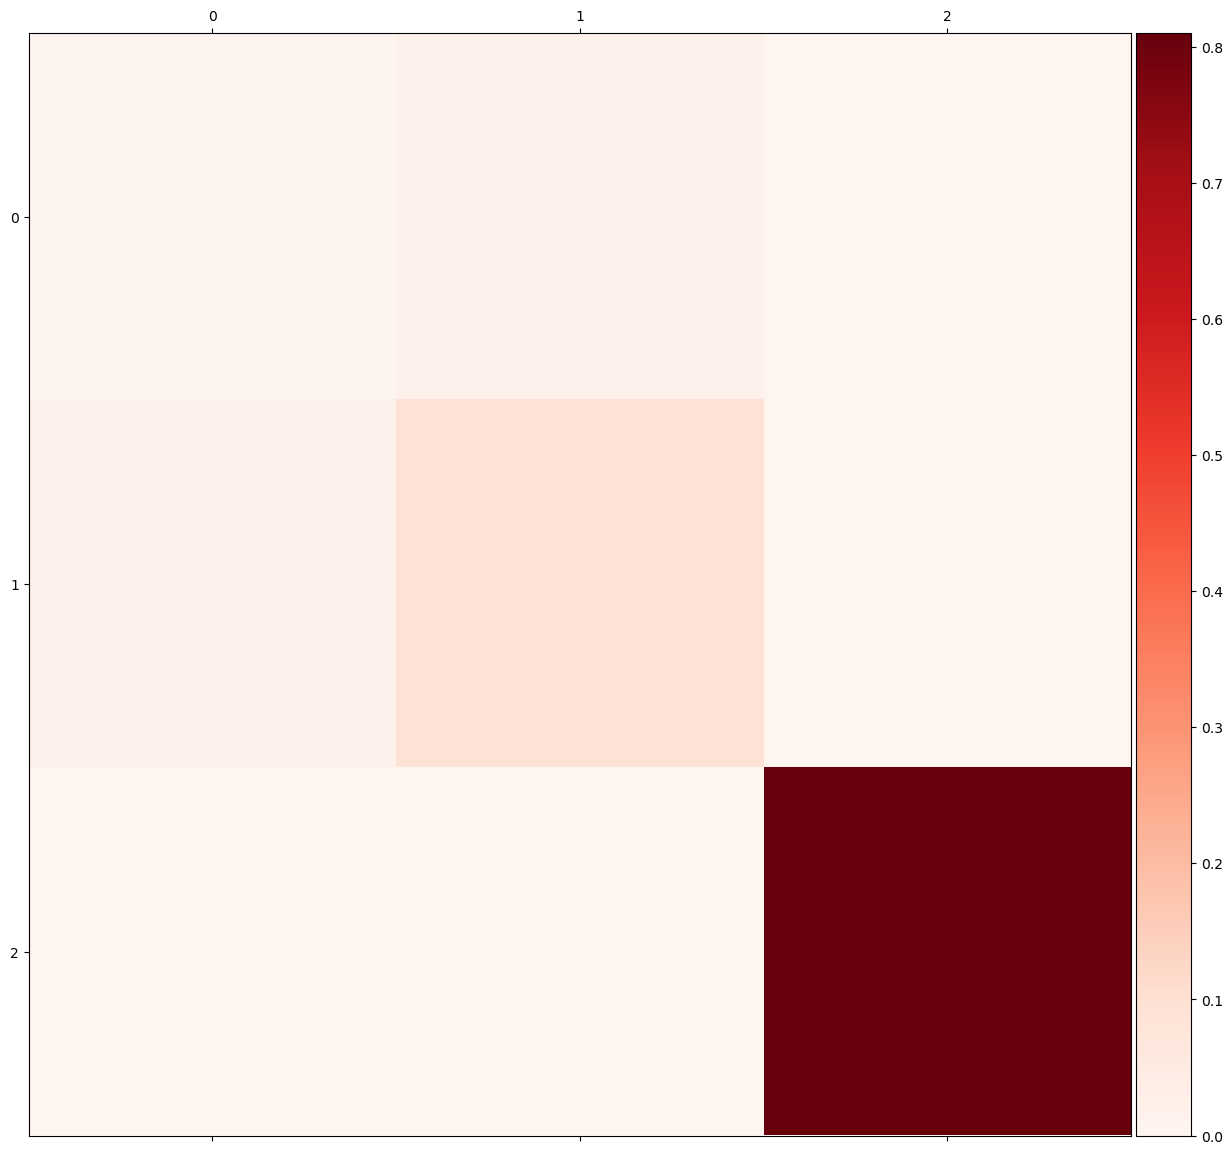

In [ ]:
fig, ax = plt.subplots(1,1,figsize=(15,15))
r = ax.matshow(cov, cmap = "Reds", vmin=0)
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)

plt.colorbar(r, cax=cax)
try:
    ax.set_xticks([x for x in range(labels_select.__len__())], labels_select, rotation='vertical');
    ax.set_yticks([x for x in range(labels_select.__len__())], labels_select);
except:
    None

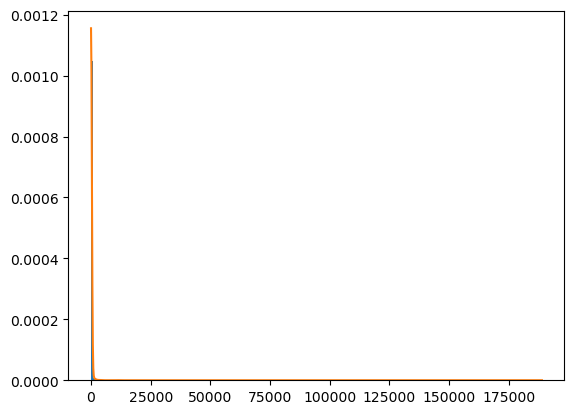

In [ ]:
plt.hist(X[2,:],bins = 200, density=True)

xx = np.linspace(X[2,:].min(), X[2,:].max(), 1000)
pdf = kernels_X[2](xx)
plt.plot(xx,pdf)

# Test for correlation

In [253]:
mi = 0
np.sqrt(1 - np.exp(-2 * mi))

0.0

## Final CI abs

CI [a,b]. Correlation different from 0. Using reflected density.
CI abs rho: [0.010709, 0.131363]


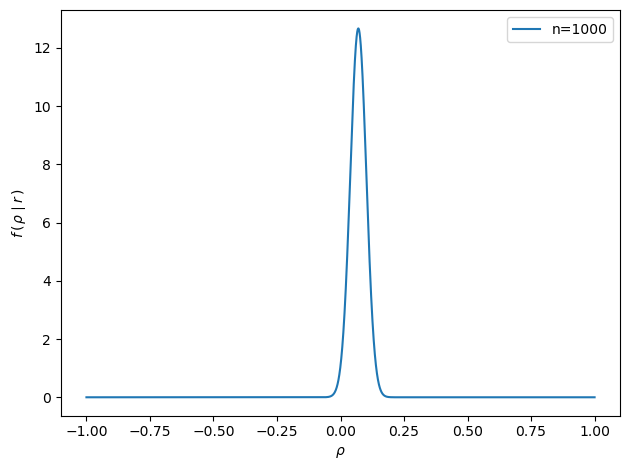

In [479]:
n = 1000
v = n-1

alpha = 0.05
r = 0.07    # sample (abs) correlation



# ensure r is non-negative
r = np.abs(r)

nomalization_const = v * (v-1) / np.sqrt(2*np.pi) * np.exp( scipy.special.loggamma(v-1) - scipy.special.loggamma(v + 0.5) )

# Check if with out abs, correlation CI contains 0
rho_bounds = np.linspace(-1,1,1_000_001)
rho = (rho_bounds[1:] + rho_bounds[:-1])/2
pdf_rho = nomalization_const * np.exp((v-1)/2 * np.log(1-r**2) + (v/2 - 1)*np.log(1-rho**2) + (0.5 - v)*np.log(1-rho*r)) * scipy.special.hyp2f1(1.5, -0.5, v+0.5, (1+rho*r)/2)
dh = (rho_bounds[-1] - rho_bounds[0]) / rho.__len__()
CI_rho = [rho_bounds[1:][np.cumsum(pdf_rho) * dh < alpha/2][-1], rho_bounds[1:][np.cumsum(pdf_rho) * dh > (1-alpha/2)][0]]


plt.plot(rho,pdf_rho, label=f"n={n}")


# prepare for next step
rho_bounds = np.linspace(0,1,1_000_001)
rho = (rho_bounds[1:] + rho_bounds[:-1])/2
pdf_abs = nomalization_const * ( np.exp((v-1)/2 * np.log(1-r**2) + (v/2 - 1)*np.log(1-rho**2) + (0.5 - v)*np.log(1-rho*r)) * scipy.special.hyp2f1(1.5, -0.5, v+0.5, (1+rho*r)/2) + np.exp((v-1)/2 * np.log(1-r**2) + (v/2 - 1)*np.log(1-rho**2) + (0.5 - v)*np.log(1+rho*r)) * scipy.special.hyp2f1(1.5, -0.5, v+0.5, (1-rho*r)/2) )
dh = (rho_bounds[-1] - rho_bounds[0]) / rho.__len__()

# If contains 0, use refelct-added density to calculate instead
if ( (CI_rho[0] <= 0 ) & (0 <= CI_rho[1]) ):
    print("CI [0,b]. Correlation not different from 0. Using reflected density.")
    CI_rho = [0, rho_bounds[1:][np.cumsum(pdf_abs) * dh > (1-alpha)][0]]

else:
    print("CI [a,b]. Correlation different from 0. Using reflected density.")
    CI_rho = [rho_bounds[1:][np.cumsum(pdf_abs) * dh < alpha/2][-1], rho_bounds[1:][np.cumsum(pdf_abs) * dh > (1-alpha/2)][0]]

# # plt_idx = (rho >-0.1) & (rho < 0.1)
# # plt.plot(rho[plt_idx],pdf_rho[plt_idx])
# plt.plot(rho,pdf_abs)
# plt.xlabel(r"$\left|\rho\right|$")
# plt.ylabel(r"$f\,\left(\,\left|\rho\right| \mid \left|r\right|\,\right)$");

plt.xlabel(r"$\rho$")
plt.ylabel(r"$f\,\left(\,\rho \mid r\,\right)$");




# print(f"probability mass: {pdf_abs.sum() * (rho_bounds[-1] - rho_bounds[0]) / pdf_abs.__len__()}")

# # Computing CI for absolute correlation
# CI_rho = [rho_bounds[1:][np.cumsum(pdf_abs) * 2 / rho.__len__() < alpha/2][-1], rho_bounds[1:][np.cumsum(pdf_abs) * (rho_bounds[-1] - rho_bounds[0]) / rho.__len__() > (1-alpha/2)][0]]

# if not ( (r >= CI_rho[0]) & (r <= CI_rho[1]) ):
#     print("CI does not contain sample, switching to other def.")
#     # rho_bounds = np.linspace(-1,1,1_000_001)
#     # rho = (rho_bounds[1:] + rho_bounds[:-1])/2
#     # pdf_rho = nomalization_const * np.exp((v-1)/2 * np.log(1-r**2) + (v/2 - 1)*np.log(1-rho**2) + (0.5 - v)*np.log(1-rho*r)) * scipy.special.hyp2f1(1.5, -0.5, v+0.5, (1+rho*r)/2)
#     CI_rho = [0, rho_bounds[1:][np.cumsum(pdf_abs) * (rho_bounds[-1] - rho_bounds[0]) / rho.__len__() > (1-alpha)][0]]
#     # CI_rho = [0, rho_bounds[1:][np.cumsum(pdf_rho) * (rho_bounds[-1] - rho_bounds[0]) / rho.__len__() > (1-alpha/2)][0]]
# # if CI_rho[0] < 0:
# #     CI_rho[0] = 0
print(f"CI abs rho: {CI_rho}")
# note that for the lower bound, we take from 1 and not 0. This is because cumsum does not return 0 as the forst element, which it should do if we wanted use from index 0

# # get the usual 1.9599 when r = 0 as we would expect from the student-t distribution


# # 0, 0.016449999999999854

# rho_bounds = np.linspace(-1,1,1_000_001)
# rho = (rho_bounds[1:] + rho_bounds[:-1])/2
# pdf_rho = nomalization_const * np.exp((v-1)/2 * np.log(1-r**2) + (v/2 - 1)*np.log(1-rho**2) + (0.5 - v)*np.log(1-rho*r)) * scipy.special.hyp2f1(1.5, -0.5, v+0.5, (1+rho*r)/2)
# plt.plot(rho,pdf_rho)
# plt.xlabel(r"$\left|\rho\right|$")
# plt.ylabel(r"$f\,\left(\,\left|\rho\right| \mid \left|r\right|\,\right)$");

# plt.xlim(-0.03, 0.03)

plt.legend()
plt.tight_layout()

## Plot of confidence distribution

CI [a,b]. Correlation different from 0. Using reflected density.
CI [a,b]. Correlation different from 0. Using reflected density.
CI [a,b]. Correlation different from 0. Using reflected density.


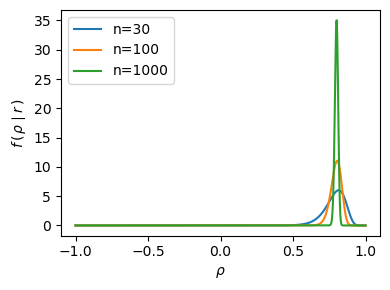

In [473]:
plt.figure(figsize=(4,3))

alpha = 0.05
r = 0.8    # sample (abs) correlation

for n in [30, 100, 1000]:

    v = n-1





    # ensure r is non-negative
    r = np.abs(r)

    nomalization_const = v * (v-1) / np.sqrt(2*np.pi) * np.exp( scipy.special.loggamma(v-1) - scipy.special.loggamma(v + 0.5) )

    # Check if with out abs, correlation CI contains 0
    rho_bounds = np.linspace(-1,1,1_000_001)
    rho = (rho_bounds[1:] + rho_bounds[:-1])/2
    pdf_rho = nomalization_const * np.exp((v-1)/2 * np.log(1-r**2) + (v/2 - 1)*np.log(1-rho**2) + (0.5 - v)*np.log(1-rho*r)) * scipy.special.hyp2f1(1.5, -0.5, v+0.5, (1+rho*r)/2)
    dh = (rho_bounds[-1] - rho_bounds[0]) / rho.__len__()
    CI_rho = [rho_bounds[1:][np.cumsum(pdf_rho) * dh < alpha/2][-1], rho_bounds[1:][np.cumsum(pdf_rho) * dh > (1-alpha/2)][0]]


    plt.plot(rho,pdf_rho, label=f"n={n}")


    # prepare for next step
    rho_bounds = np.linspace(0,1,1_000_001)
    rho = (rho_bounds[1:] + rho_bounds[:-1])/2
    pdf_abs = nomalization_const * ( np.exp((v-1)/2 * np.log(1-r**2) + (v/2 - 1)*np.log(1-rho**2) + (0.5 - v)*np.log(1-rho*r)) * scipy.special.hyp2f1(1.5, -0.5, v+0.5, (1+rho*r)/2) + np.exp((v-1)/2 * np.log(1-r**2) + (v/2 - 1)*np.log(1-rho**2) + (0.5 - v)*np.log(1+rho*r)) * scipy.special.hyp2f1(1.5, -0.5, v+0.5, (1-rho*r)/2) )
    dh = (rho_bounds[-1] - rho_bounds[0]) / rho.__len__()

    # If contains 0, use refelct-added density to calculate instead
    if ( (CI_rho[0] <= 0 ) & (0 <= CI_rho[1]) ):
        print("CI [0,b]. Correlation not different from 0. Using reflected density.")
        CI_rho = [0, rho_bounds[1:][np.cumsum(pdf_abs) * dh > (1-alpha)][0]]

    else:
        print("CI [a,b]. Correlation different from 0. Using reflected density.")
        CI_rho = [rho_bounds[1:][np.cumsum(pdf_abs) * dh < alpha/2][-1], rho_bounds[1:][np.cumsum(pdf_abs) * dh > (1-alpha/2)][0]]

    # # plt_idx = (rho >-0.1) & (rho < 0.1)
    # # plt.plot(rho[plt_idx],pdf_rho[plt_idx])
    # plt.plot(rho,pdf_abs)
    # plt.xlabel(r"$\left|\rho\right|$")
    # plt.ylabel(r"$f\,\left(\,\left|\rho\right| \mid \left|r\right|\,\right)$");

plt.xlabel(r"$\rho$")
plt.ylabel(r"$f\,\left(\,\rho \mid r\,\right)$");




# print(f"probability mass: {pdf_abs.sum() * (rho_bounds[-1] - rho_bounds[0]) / pdf_abs.__len__()}")

# # Computing CI for absolute correlation
# CI_rho = [rho_bounds[1:][np.cumsum(pdf_abs) * 2 / rho.__len__() < alpha/2][-1], rho_bounds[1:][np.cumsum(pdf_abs) * (rho_bounds[-1] - rho_bounds[0]) / rho.__len__() > (1-alpha/2)][0]]

# if not ( (r >= CI_rho[0]) & (r <= CI_rho[1]) ):
#     print("CI does not contain sample, switching to other def.")
#     # rho_bounds = np.linspace(-1,1,1_000_001)
#     # rho = (rho_bounds[1:] + rho_bounds[:-1])/2
#     # pdf_rho = nomalization_const * np.exp((v-1)/2 * np.log(1-r**2) + (v/2 - 1)*np.log(1-rho**2) + (0.5 - v)*np.log(1-rho*r)) * scipy.special.hyp2f1(1.5, -0.5, v+0.5, (1+rho*r)/2)
#     CI_rho = [0, rho_bounds[1:][np.cumsum(pdf_abs) * (rho_bounds[-1] - rho_bounds[0]) / rho.__len__() > (1-alpha)][0]]
#     # CI_rho = [0, rho_bounds[1:][np.cumsum(pdf_rho) * (rho_bounds[-1] - rho_bounds[0]) / rho.__len__() > (1-alpha/2)][0]]
# # if CI_rho[0] < 0:
# #     CI_rho[0] = 0
# print(f"CI abs rho: {CI_rho}")
# note that for the lower bound, we take from 1 and not 0. This is because cumsum does not return 0 as the forst element, which it should do if we wanted use from index 0

# # get the usual 1.9599 when r = 0 as we would expect from the student-t distribution


# # 0, 0.016449999999999854

# rho_bounds = np.linspace(-1,1,1_000_001)
# rho = (rho_bounds[1:] + rho_bounds[:-1])/2
# pdf_rho = nomalization_const * np.exp((v-1)/2 * np.log(1-r**2) + (v/2 - 1)*np.log(1-rho**2) + (0.5 - v)*np.log(1-rho*r)) * scipy.special.hyp2f1(1.5, -0.5, v+0.5, (1+rho*r)/2)
# plt.plot(rho,pdf_rho)
# plt.xlabel(r"$\left|\rho\right|$")
# plt.ylabel(r"$f\,\left(\,\left|\rho\right| \mid \left|r\right|\,\right)$");

# plt.xlim(-0.03, 0.03)

plt.legend()
plt.tight_layout()



# plt.savefig(figures_path + "Gaussian correlation confidence dist/density comparison r 0.8.pdf", bbox_inches='tight')

In [20]:
temp = -0.5 * np.log(1 - cor**2)
np.fill_diagonal(temp, 0)
# temp = temp @ np.linalg.pinv(np.eye(3) - temp)
temp

C:\Users\jonas\AppData\Local\Temp\ipykernel_24688\1580882354.py:1: RuntimeWarning: divide by zero encountered in log
  temp = -0.5 * np.log(1 - cor**2)


array([[ 0.       ,  0.8303656, -0.       ],
       [ 0.8303656,  0.       , -0.       ],
       [-0.       , -0.       ,  0.       ]])

In [31]:
A = np.ones((3,3)) * 7
# A[0,1] = A[1,0] = 0
np.linalg.eig(A)

EigResult(eigenvalues=array([2.10000000e+01, 0.00000000e+00, 1.62635101e-15]), eigenvectors=array([[ 5.77350269e-01,  1.02237325e-16,  6.90643277e-01],
       [ 5.77350269e-01, -7.07106781e-01, -7.22493878e-01],
       [ 5.77350269e-01,  7.07106781e-01,  3.18506015e-02]]))

In [22]:
np.linalg.eig(temp * 0.5/0.84)

EigResult(eigenvalues=array([ 0.49426524, -0.49426524,  0.        ]), eigenvectors=array([[ 0.70710678, -0.70710678,  0.        ],
       [ 0.70710678,  0.70710678,  0.        ],
       [ 0.        ,  0.        ,  1.        ]]))

In [16]:
temp = cor.copy()
np.fill_diagonal(temp,0)
temp = np.triu(temp)
temp @ np.linalg.pinv(np.eye(3) - temp)

array([[-4.99600361e-17,  9.00000000e-01,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00]])

# error mutual information

C:\Users\jonas\AppData\Local\Temp\ipykernel_24688\1422182999.py:2: RuntimeWarning: divide by zero encountered in log
  return -0.5 * np.log(1 - x**2 * y**2) - 0.25 * np.log(1 - x**2) * np.log(1 - y**2)
C:\Users\jonas\AppData\Local\Temp\ipykernel_24688\1422182999.py:2: RuntimeWarning: invalid value encountered in multiply
  return -0.5 * np.log(1 - x**2 * y**2) - 0.25 * np.log(1 - x**2) * np.log(1 - y**2)
C:\Users\jonas\AppData\Local\Temp\ipykernel_24688\1422182999.py:2: RuntimeWarning: invalid value encountered in subtract
  return -0.5 * np.log(1 - x**2 * y**2) - 0.25 * np.log(1 - x**2) * np.log(1 - y**2)


plotting surface


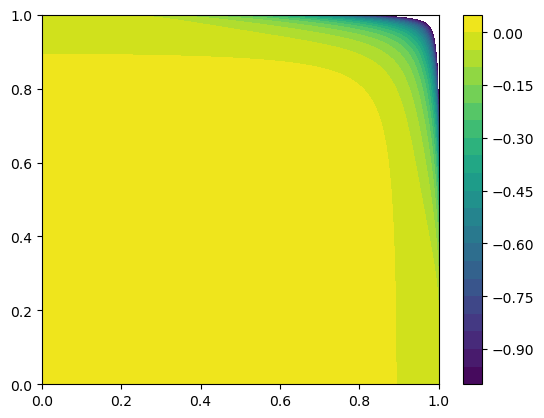

In [81]:
def MIError(x,y):
    return -0.5 * np.log(1 - x**2 * y**2) - 0.25 * np.log(1 - x**2) * np.log(1 - y**2)

xx, yy = np.meshgrid(np.linspace(0,1,3_000), np.linspace(0,1,3_000))

# fig,ax = plt.subplots(subplot_kw={"projection": "3d"})
zz = MIError(xx,yy)
zz[np.abs(zz) > 1] = np.nan

print("plotting surface")
# ax.plot_surface(xx,yy,zz,cmap=cm.coolwarm, antialiased=False)


# plt.show()

# plt.imshow(zz,origin='lower',interpolation='bilinear')
# plt.show()


plt.contourf(xx,yy,zz, 20)
plt.colorbar(extend = "neither")

C:\Users\jonas\AppData\Local\Temp\ipykernel_24688\3596734464.py:2: RuntimeWarning: divide by zero encountered in log
  return -0.5 * np.log(1 - x**2 * y**2 * rho3**2) - 0.125 * np.log(1 - x**2) * np.log(1 - y**2) * np.log(1 - rho3**2)
C:\Users\jonas\AppData\Local\Temp\ipykernel_24688\3596734464.py:2: RuntimeWarning: invalid value encountered in multiply
  return -0.5 * np.log(1 - x**2 * y**2 * rho3**2) - 0.125 * np.log(1 - x**2) * np.log(1 - y**2) * np.log(1 - rho3**2)


plotting surface


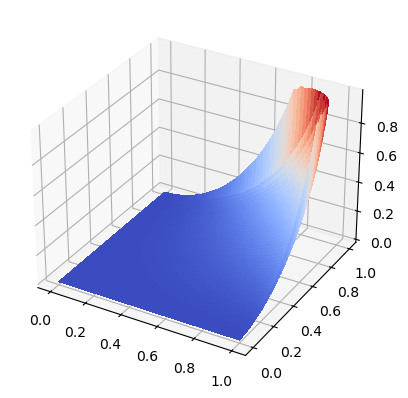

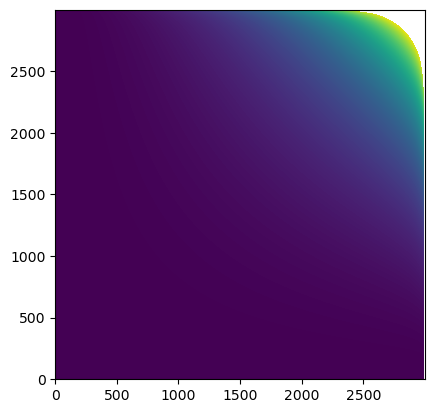

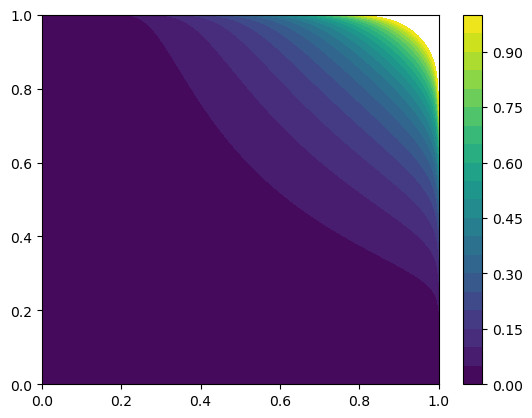

In [78]:
def MIError(x,y, rho3 = 0.8):
    return -0.5 * np.log(1 - x**2 * y**2 * rho3**2) - 0.125 * np.log(1 - x**2) * np.log(1 - y**2) * np.log(1 - rho3**2)

xx, yy = np.meshgrid(np.linspace(0,1,3_000), np.linspace(0,1,3_000))

fig,ax = plt.subplots(subplot_kw={"projection": "3d"})
zz = MIError(xx,yy)
zz[np.abs(zz) > 1] = np.nan

print("plotting surface")
ax.plot_surface(xx,yy,zz,cmap=cm.coolwarm, antialiased=False)
# ax.view_init(90, 0)
plt.show()

plt.imshow(zz,origin='lower',interpolation='bilinear')
plt.show()

plt.contourf(xx,yy,zz, 20, vmax = 1)
plt.colorbar(extend = "neither")

In [2]:
import numpy as np

In [79]:
# L = np.array([[1,0,0],[0.5,1,0],[0,0,1]])
L = np.array([[1,0,0],[0.5,(1 - 0.5**2)**0.5,0],[0,0.5,(1 - 0.5**2)**0.5]])
P = np.zeros((3,3))
P[0,1] = 1
P[1,2] = 1
P[2,0] = 1


L

array([[1.       , 0.       , 0.       ],
       [0.5      , 0.8660254, 0.       ],
       [0.       , 0.5      , 0.8660254]])

In [80]:
L @ L.T

array([[1.       , 0.5      , 0.       ],
       [0.5      , 1.       , 0.4330127],
       [0.       , 0.4330127, 1.       ]])

In [81]:
P @ L @ L.T @ P.T

array([[1.       , 0.4330127, 0.5      ],
       [0.4330127, 1.       , 0.       ],
       [0.5      , 0.       , 1.       ]])

In [92]:
G_obs = -0.5 * np.log( 1 - (L @ L.T)**2)
np.fill_diagonal(G_obs, 0)
print(G_obs)
ND(G_obs)

[[ 0.          0.14384104 -0.        ]
 [ 0.14384104  0.          0.10381968]
 [-0.          0.10381968  0.        ]]


C:\Users\jonas\AppData\Local\Temp\ipykernel_31804\4294099351.py:1: RuntimeWarning: divide by zero encountered in log
  G_obs = -0.5 * np.log( 1 - (L @ L.T)**2)


array([[-0.21624196,  0.53606188, -0.15607626],
       [ 0.53606188, -0.32889262,  0.38691166],
       [-0.15607626,  0.38691166, -0.11265066]])

In [91]:
G_obs = -0.5 * np.log( 1 - (P @ L @ L.T @ P.T)**2)
np.fill_diagonal(G_obs, 0)
print(G_obs)
ND(G_obs)

[[ 0.          0.10381968  0.14384104]
 [ 0.10381968  0.         -0.        ]
 [ 0.14384104 -0.          0.        ]]


C:\Users\jonas\AppData\Local\Temp\ipykernel_31804\3461153774.py:1: RuntimeWarning: divide by zero encountered in log
  G_obs = -0.5 * np.log( 1 - (P @ L @ L.T @ P.T)**2)


array([[-0.32889262,  0.38691166,  0.53606188],
       [ 0.38691166, -0.11265066, -0.15607626],
       [ 0.53606188, -0.15607626, -0.21624196]])

In [71]:
np.linalg.cholesky(P @ L @ L.T @ P.T)

array([[ 1.        ,  0.        ,  0.        ],
       [ 0.4330127 ,  0.90138782,  0.        ],
       [ 0.5       , -0.24019223,  0.83205029]])

In [53]:
P = np.eye(10)

i = 2
j = 5
P[i,j] = 1
P[j,i] = 1
P[i,i] = 0
P[j,j] = 0


np.linalg.det(P)

-1.0